# DPhi Data Sprint 91 - Pharmaceutical Drug Recognition: 
Identify the Pharmaceutical Drug used from the given images

## Context

Issuing of correct prescriptions is the mainstay of patient safety. Medication errors are the most important problem that influences safety in health care . The most common medication errors are caused by human factors, such as fatigue and inadequate knowledge. In particular, look-alike and sound-alike (LASA) is the lead error at the level of pharmacists or physicians.

 

A good policy to prevent LASA is to change drug names and their packaging. Researchers used chart reviews and mathematical methods to identify problematic pairs of drug names, and constructed an automated detection system to detect and prevent LASA errors. Unfortunately, major problems remain in drug identification: many drugs look alike; drugs are relatively small in size; and a large number of drugs need to be identified. Existing identification solutions still have their limitations 

 

Alternatively, image-based solutions have been developed. Most significantly, thanks to the vigorous development of Graphics Processing Units (GPUs) for parallel computing, a current mainstream process is to adopt deep learning methods to replace traditional classifiers.

## Obective

Your Task is to come up with a Deep Learning Algorithm that helps the doctors to successfully classify the pharmaceutical drugs thereby reducing any unnecessary mishaps.

## About Data

The dataset features 10 different classes of Pharmaceutical Drugs. The dataset contains about 9500+ labelled images including the validation images. Each image belongs to only one drug category and are saved in separate folders of the labelled classes

From the above link you will be able to download a zip file named ‘Pharmaceutical_drug.zip’. After you extract this zip file, you will get four files:

Train - contains all the images that are to be used for training your model.  In this folder you will find 10 folders’ which contain the images of the respective drug categories

Test - contains 4500  images of drug categories. For these images you are required to make predictions as the respective class names.

Testing_set.csv - this is the order of the predictions for each image that is to be submitted on the platform. Make sure the predictions you download are with their image’s filename in the same order as given in this file.

sample_submission: This is a csv file that contains the sample submission for the data sprint.

see more [here](https://dphi.tech/challenges/data-sprint-91-pharmaceutical-drug-recognition/296/data) . I had alread downloaded the zip file and saved to my google drive

## Setup

In [1]:
## mount drive as the data is stored in it.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install --upgrade -q fastai

In [3]:
##import the necessary libraries
# import fastai
from fastai.vision.all import *
set_seed(42)
import os
import pathlib, shutil
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# set_seed(42,True)

In [4]:
## extract all the required files to colab tmp folder
base_path = '/tmp'
image_dir = os.path.join(base_path, 'images')
if not os.path.isdir(image_dir):
  os.mkdir(image_dir)
  zip_ref = zipfile.ZipFile('/content/drive/MyDrive/pharmaceutical_drug.zip')
  zip_ref.extractall(image_dir)
  zip_ref.close()

## Loading the data

In [5]:
train = pd.read_csv('/tmp/images/Training_set.csv')
test = pd.read_csv('/tmp/images/Testing_set.csv')

train.head()

,filename,label
0,Image_1.jpg,Bioflu
1,Image_2.jpg,Bactidol
2,Image_3.jpg,Fish Oil
3,Image_4.jpg,Fish Oil
4,Image_5.jpg,Bioflu


## Expository Data Analysis(EDA)

In [6]:
# check image count in train and test set
print(f'The train set has {train.shape[0]} images \n while the test set has {test.shape[0]} images')

The train set has 7000 images 
 while the test set has 3000 images


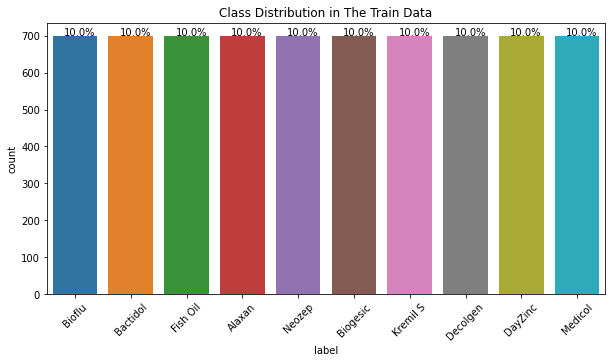

In [7]:
## check the class distribution in the train dataset

plt.figure(figsize=(10,5))
ax = sns.countplot(x = 'label', data = train)
size = len(train)
for p in ax.patches:
  height, width = p.get_height(), p.get_width()
  x, y = p.get_x(), p.get_y()
  percent = round(height/size * 100, 2)
  label = f'{percent}%'
  ax.annotate(label,(x + width/2- width/4, height))

plt.xticks(rotation=45)
plt.title('Class Distribution in The Train Data')
plt.show()

In [8]:
##create a function to view sample images from the train set

path = '/tmp/images/train'
def plot_images(df):
  images = list(df['filename'][:25])
  files = [os.path.join(path, img) for img in images]
  imgs = [Image.open(file) for file in files]

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(5*w, 5*h))
  grid_w, grid_h = grid.size
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%5*w, i//5*h))
  return grid

# see sample image sizes in the train set
def img_size(df):
  images = list(df['filename'][:5])
  files = [os.path.join(path, img) for img in images]
  imgs = [Image.open(file) for file in files]
  for i, img in enumerate(imgs):
     print(img.size)

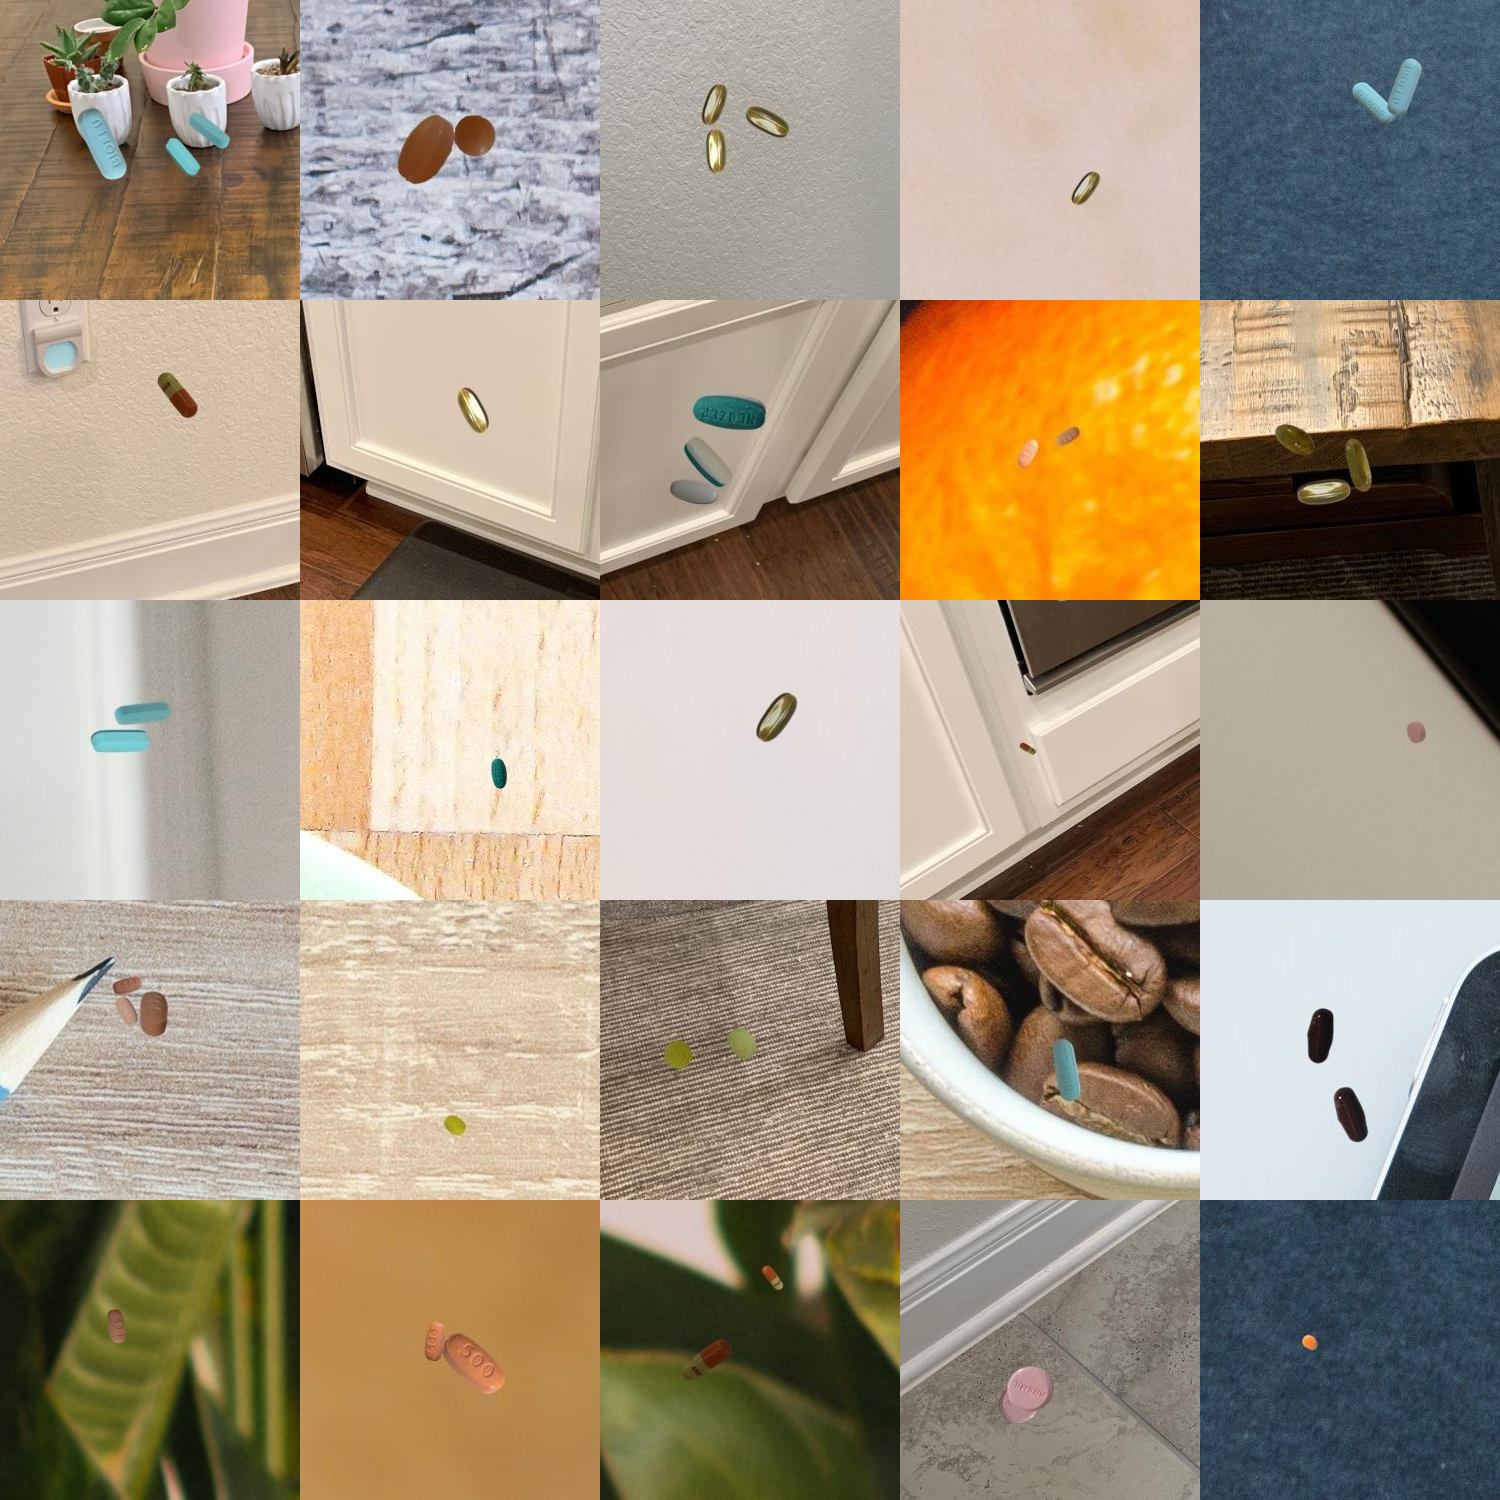

In [9]:
plot_images(train)

In [10]:
img_size(train)

(300, 300)
(300, 300)
(300, 300)
(300, 300)
(300, 300)


## Data Preparetion And Modelling

create a data loaders for the image files, labels are gotten from the csv file

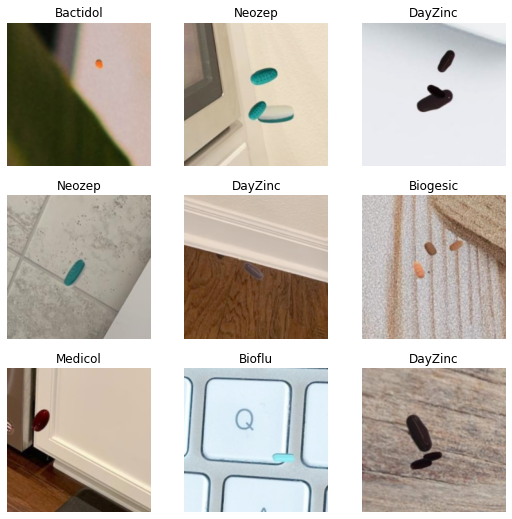

In [11]:
dls = ImageDataLoaders.from_df(train, fn_col='filename', label_col='label', 
                               folder='/tmp/images/train',
                               batch_tfms = aug_transforms(size=224, min_scale=0.75)) # item_tfms=Resize(400, method='squish')
dls.show_batch() # Note the augmentation applied to the images!

### Build A Base Model

From the eda part, we can see that the training set is small and the best approach to this task will be transfer learning. Lets start with resnet18. 

In [12]:
learn = vision_learner(dls, resnet18, metrics = accuracy)
learn.fine_tune(7)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,1.508075,0.612602,0.808571,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.431002,0.227201,0.925000,00:26
1,0.230743,0.155377,0.948571,00:26
2,0.138983,0.134940,0.960000,00:25
3,0.083081,0.111296,0.963571,00:25
4,0.053816,0.117797,0.964286,00:25
5,0.036349,0.090815,0.974286,00:26
6,0.024487,0.085702,0.976429,00:25


#### Making First Submission With Base Model
The base model had 97% accuracy but looking at the train and validation loss, more improvements canbe made by training longer but make our first submission.

In [15]:
# create dictionary that maps index to class names
idx2class = {i : name for i, name in enumerate(dls.vocab)}
idx2class

{0: 'Alaxan',
 1: 'Bactidol',
 2: 'Bioflu',
 3: 'Biogesic',
 4: 'DayZinc',
 5: 'Decolgen',
 6: 'Fish Oil',
 7: 'Kremil S',
 8: 'Medicol',
 9: 'Neozep'}

In [20]:
# make pred using without test time augmentation and compare results
test_dl = dls.test_dl(get_image_files('/tmp/images/test')) # get test image dataloader
preds, _, labels = learn.get_preds(dl=test_dl, with_decoded=True) # make predictions
files = os.listdir('/tmp/images/test')  # get test image files in other of predition
submission = pd.DataFrame({'filename' : files, 'label' : labels}) # craete submission dataframe
submission = pd.merge(test, submission, on = 'filename', how= 'left') # rearrage submission file asin test dataframe
submission['label'] = submission['label'].map(idx2class) # map class index to names
submission.to_csv('mybase_submission.csv', index=False) # save csv

In [25]:
# make pred using with test time augmentation and compare results
test_dl = dls.test_dl(get_image_files('/tmp/images/test'))
preds, _= learn.tta(dl=test_dl)
labels = torch.argmax(preds, axis = -1)
files = os.listdir('/tmp/images/test')
submission = pd.DataFrame({'filename' : files, 'label' : labels})
submission = pd.merge(test, submission, on = 'filename', how= 'left')
submission['label'] = submission['label'].map(idx2class)
submission.to_csv('mybase_submission_tta.csv', index=False)

Without tta our model achieved an accuracy of 97.92% on test set and with tta accuracy increased to 99.08. Thats a great improvement

### Improving The Base Model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SuggestedLRs(valley=0.001737800776027143, slide=0.0030199517495930195)

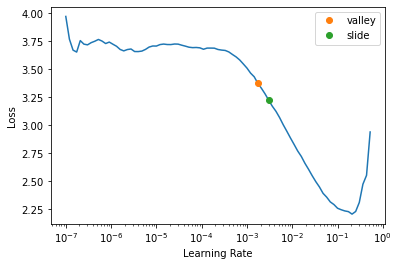

In [71]:
## find the perfect learning rate
## Train Longer
learn = vision_learner(dls, resnet18, metrics = accuracy)
learn.lr_find(suggest_funcs=(valley, slide))

In [72]:
learn.fine_tune(20,0.01, cbs = SaveModelCallback(every_epoch = True,  fname = 'model'))

epoch,train_loss,valid_loss,accuracy,time
0,0.997322,0.474357,0.864286,00:22


epoch,train_loss,valid_loss,accuracy,time
0,0.230425,0.136902,0.953571,00:25
1,0.118592,0.173661,0.949286,00:25
2,0.136340,0.200632,0.937857,00:26
3,0.131302,0.197721,0.948571,00:25
4,0.131730,0.286388,0.933571,00:25
5,0.105551,0.204241,0.950714,00:25
6,0.113703,0.120671,0.965714,00:25
7,0.096405,0.112569,0.967143,00:25
8,0.090783,0.185187,0.950000,00:25
9,0.075788,0.134920,0.970714,00:25


epoch,train_loss,valid_loss,accuracy,time
0,0.230425,0.136902,0.953571,00:25
1,0.118592,0.173661,0.949286,00:25
2,0.136340,0.200632,0.937857,00:26
3,0.131302,0.197721,0.948571,00:25
4,0.131730,0.286388,0.933571,00:25
5,0.105551,0.204241,0.950714,00:25
6,0.113703,0.120671,0.965714,00:25
7,0.096405,0.112569,0.967143,00:25
8,0.090783,0.185187,0.950000,00:25
9,0.075788,0.134920,0.970714,00:25


#### View model performance

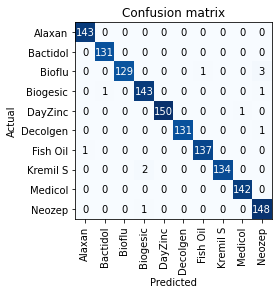

In [74]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

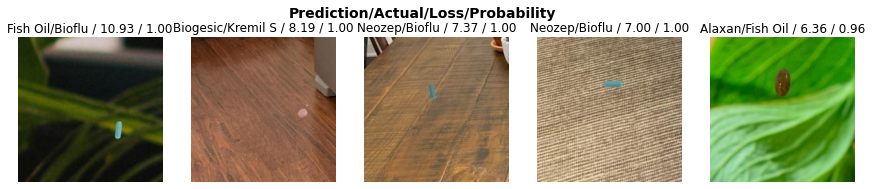

In [75]:
interp.plot_top_losses(5, nrows = 1)

Looking at the drugs with high losses above, we can see that the pictures are faint compared to the bright pictures from the train batch viewed above. This might be the reason for the bad predictions and can possibily be solved by test time augumentation. Lets verify this below

In [76]:
## check performance again
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)
print(accuracy(preds, targs))

tta_preds,_ = learn.tta(dl=valid)  # see effect of test time augumentation
print(accuracy(tta_preds, targs))

TensorBase(0.9914)


TensorBase(0.9957)


#### Make final prediction on test set

In [73]:
test_dl = dls.test_dl(get_image_files('/tmp/images/test'))
preds, _= learn.tta(dl=test_dl)
labels = torch.argmax(preds, axis = -1)
files = os.listdir('/tmp/images/test')
submission = pd.DataFrame({'filename' : files, 'label' : labels})
submission = pd.merge(test, submission, on = 'filename', how= 'left')
submission['label'] = submission['label'].map(idx2class)
submission.to_csv('submission6_tta.csv', index=False)

## Evaluation
**Public LeaderBoard Score: 100%**

**Public LeaderBoard Position: 1st**

## Summary

The data was a simple one. There was no need for model ensembling, gradient accumulation, label smoothing, Mixup, or even using dipper architectures. Finding learning rate and training longer (20 epochs) was all I needed.
